# Climate Risk Assessment


## Preparations


Since I used a virtual environment, please use this kernel for reproduibility purposes...

In [19]:
import importlib
import subprocess
import sys

def install_packages(packages):
    for package in packages:
        try:
            importlib.import_module(package)
            print(f"{package} is already installed!")
        except ImportError:
            print(f"{package} is not installed, installing now...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"{package} has been installed successfully!")


In [20]:
# Packages we used for this study
packages = ['numpy', 'pandas', 'matplotlib', 'intake', 'datetime', 'plotly', 'intake-esm', 'pathlib', 'requests',
           'aiohttp', 's3fs', 'xarray', 'fsspec', 'warnings', 'dask' , 'cartopy', 'netcdf4', 'MetPy','seaborn']

# Call the function to install all packages from the 
install_packages(packages)

numpy is already installed!
pandas is already installed!
matplotlib is already installed!
intake is already installed!
datetime is already installed!
plotly is already installed!
intake-esm is not installed, installing now...
intake-esm has been installed successfully!
pathlib is already installed!
requests is already installed!
aiohttp is already installed!
s3fs is already installed!
xarray is already installed!
fsspec is already installed!
warnings is already installed!
dask is already installed!
cartopy is already installed!
netcdf4 is not installed, installing now...
netcdf4 has been installed successfully!
MetPy is not installed, installing now...
MetPy has been installed successfully!
seaborn is not installed, installing now...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.8 MB/s eta 0:00:00
seaborn has been installed successfully!


In [21]:
# import all packages from the same kernel we used (ensures reproducibility)
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import xarray as xr
import cartopy.crs as ccrs
import seaborn as sns

import intake
import requests
import aiohttp
import fsspec
import s3fs
import warnings

from cartopy.feature import COASTLINE
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

from dask.diagnostics import ProgressBar
from pathlib import Path
from datetime import time
from scipy.stats import linregress
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Data Download

Since the dataset is huge, we can not provide it on Github but you can download it (huge data set!)

In [9]:
col_url = ("https://ncar-cesm2-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm2-le.json")
catalog = intake.open_esm_datastore(col_url)

In [25]:
df= catalog.df[["variable", "long_name", "vertical_levels", "units", "spatial_domain"]].drop_duplicates()
print(df)

In [51]:
df_1 = xr.open_dataset("../data-raw/historic_010.nc", engine="netcdf4")
df_2 = xr.open_dataset("../data-raw/historic_1020.nc", engine="netcdf4")
df_3 = xr.open_dataset("../data-raw/historic_2030.nc", engine="netcdf4")
df_4 = xr.open_dataset("../data-raw/historic_3040.nc", engine="netcdf4")
df_5 = xr.open_dataset("../data-raw/historic_4050.nc", engine="netcdf4")
# Concatenate along 'member_id'
df_historic = xr.concat([df_1, df_2, df_3, df_4, df_5], dim='member_id')

df_1 = xr.open_dataset("../data-raw/future_010.nc", engine="netcdf4")
df_2 = xr.open_dataset("../data-raw/future_1020.nc", engine="netcdf4")
df_3 = xr.open_dataset("../data-raw/future_2030.nc", engine="netcdf4")
df_4 = xr.open_dataset("../data-raw/future_3040.nc", engine="netcdf4")
df_5 = xr.open_dataset("../data-raw/future_4050.nc", engine="netcdf4")
# Concatenate along 'member_id'
df_future = xr.concat([df_1, df_2, df_3, df_4, df_5], dim='member_id')

# Preprocess the Data

In the next cache we define all functions we need to estimate wet-bulb temperture.

In [52]:
# FUNCTION: Calculate saturation vapor pressure (hPa) from temperature (°C) using Magnus Formula
def saturation_vapor_pressure(T_C):
    return 6.112 * np.exp((17.67 * T_C) / (T_C + 243.5))

# FUNCTION: Calculate vapor pressure (hPa) from specific humidity (kg/kg and pressure (Pa)
def actual_vapor_pressure(Q, P):
    return (Q * P) / (0.622 + 0.378 * Q) / 100  # divide by 100 to convert Pa to hPa

# FUNCTION: Calculate relative humidity (%) from specific humidity (Q in kg/kg), temperature (T_C in °C), and pressure (P in Pa)
def relative_humidity(Q, T_C, P):
    e_s = saturation_vapor_pressure(T_C)  # in hPa
    e = actual_vapor_pressure(Q, P)       # in hPa
    return (e / e_s) * 100                # multiply by 100 to convert in percent

# FUNCTION: Approximate wet-bulb temperature (°C) using Stull's formula
def wet_bulb_temperature(T, RH):
    return (T * np.arctan(0.151977 * np.sqrt(RH + 8.313659))
            + np.arctan(T + RH)
            - np.arctan(RH - 1.676331)
            + 0.00391838 * RH**1.5 * np.arctan(0.023101 * RH)
            - 4.686035)

In [53]:
# Convert temperature from K to °C 
T_hist = df_historic['TREFHTMX'] - 273.15  
T_fut = df_future['TREFHTMX'] - 273.15  
# Convert specific humidity from g/kg to kg/kg 
Q_hist = df_historic['Q'] * 1000
Q_fut = df_future['Q'] * 1000
# Convert pressure from Pa to hPa 
P_hist = df_historic['PS'] / 100
P_fut = df_future['PS'] / 100

# FUNCTION CALL: 
RH_hist = relative_humidity(Q_hist, T_hist, P_hist)
RH_fut = relative_humidity(Q_fut, T_fut, P_fut)

# Limit RH between 0 and 100%
RH_hist = RH_hist.clip(min=0, max=100)
RH_fut = RH_fut.clip(min=0, max=100)

#  FUNCTION CALL: Compute wet-bulb temperature in °C
T_wb_hist = wet_bulb_temperature(T_hist, RH_hist)
T_wb_fut = wet_bulb_temperature(T_fut, RH_fut)

# Create a DataArray for wet-bulb temperature with proper dims and coords
T_wb_hist = xr.DataArray(
    T_wb_hist,
    dims=df_historic['TREFHTMX'].dims,
    coords=df_historic['TREFHTMX'].coords,
    attrs={'units': 'degC', 'long_name': 'Wet-bulb Temperature'})

T_wb_fut = xr.DataArray(
    T_wb_fut,
    dims=df_future['TREFHTMX'].dims,
    coords=df_future['TREFHTMX'].coords,
    attrs={'units': 'degC', 'long_name': 'Wet-bulb Temperature'})

# Add it to your dataset
df_historic['T_WB'] = T_wb_hist
df_future['T_WB'] = T_wb_fut

In [44]:
# Save and store the processed netCDF files in the desired folder
df_historic.to_netcdf(
    path="../data/historic.nc",
    mode="w",
    format="NETCDF4",
    engine="netcdf4"
)

df_future.to_netcdf(
    path="../data/future.nc",
    mode="w",
    format="NETCDF4",
    engine="netcdf4"
)

PermissionError: [Errno 13] Permission denied: '/home/patrick/Documents/climate_risk_assessment/data/historic.nc'

# Analysis

In [54]:
df_historic = xr.open_dataset("../data/historic.nc", engine="netcdf4")
df_future = xr.open_dataset("../data/future.nc", engine="netcdf4")

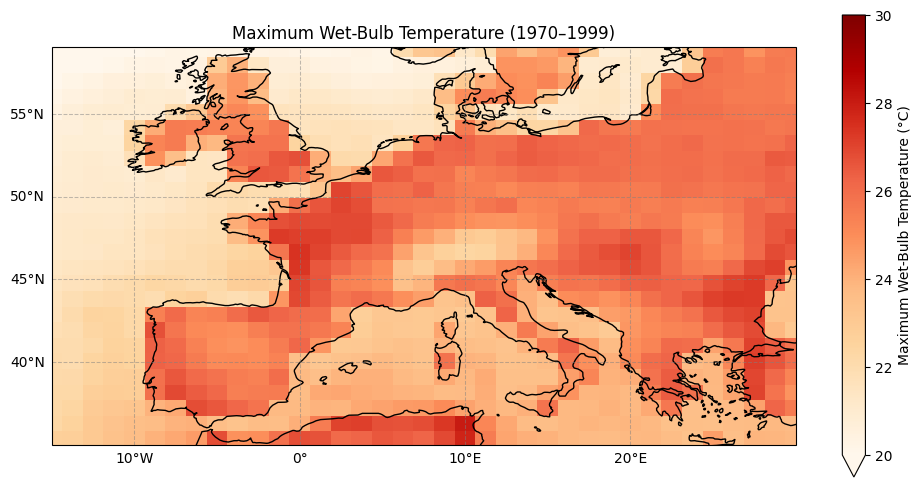

In [11]:

# Compute max wet-bulb temperature at each grid cell
max_T_WB = df_historic['T_WB'].max(dim=['member_id', 'time'])

# Plot the maximum T_WB
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
max_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': 'Maximum Wet-Bulb Temperature (°C)'},
    vmin=20, vmax=30)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title('Maximum Wet-Bulb Temperature (1970–1999)')

plt.savefig('../analysis/figures/max_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

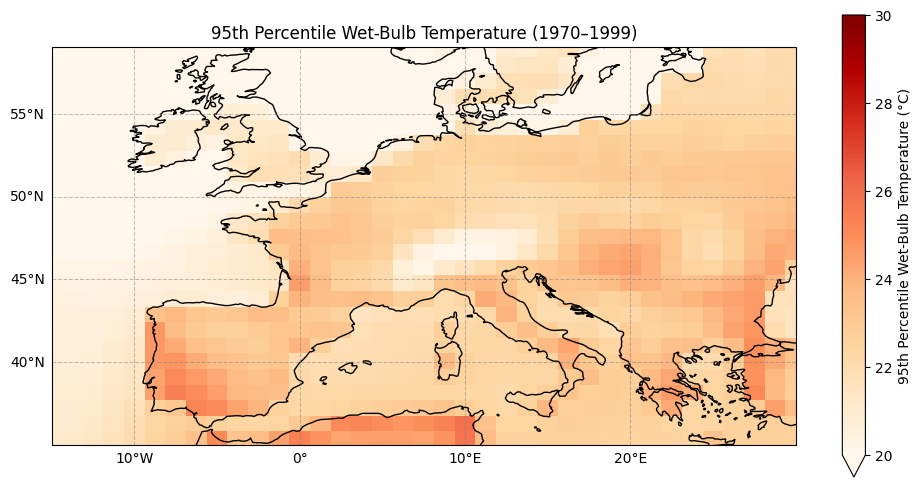

In [12]:
# Compute the 95th percentile wet-bulb temperature at each grid cell
p95_T_WB = df_historic['T_WB'].quantile(0.95, dim=['member_id', 'time'])


plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the 95th percentile T_WB
p95_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # or try 'inferno', 'plasma', 'cividis'
    cbar_kwargs={'label': '95th Percentile Wet-Bulb Temperature (°C)'},
    vmin=20, vmax=30  # adjust range to your data
)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title('95th Percentile Wet-Bulb Temperature (1970–1999)')

plt.savefig('../analysis/figures/p95_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()


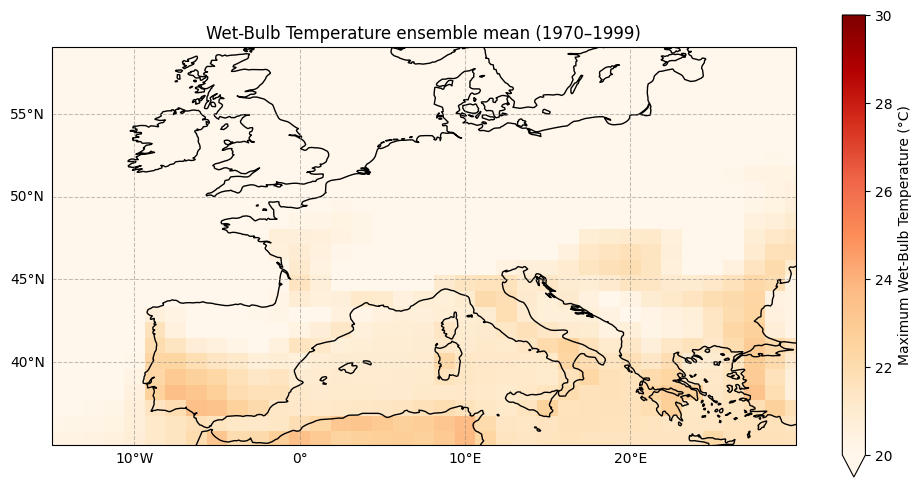

In [13]:
# Compute ensemble mean wet-bulb temperature at each grid cell
mean_T_WB = df_historic['T_WB'].mean(dim=['member_id', 'time'])

plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
mean_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': 'Maximum Wet-Bulb Temperature (°C)'},
    vmin=20, vmax=30)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title('Wet-Bulb Temperature ensemble mean (1970–1999)')

plt.savefig('../analysis/figures/ensemblemean_T_WB_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

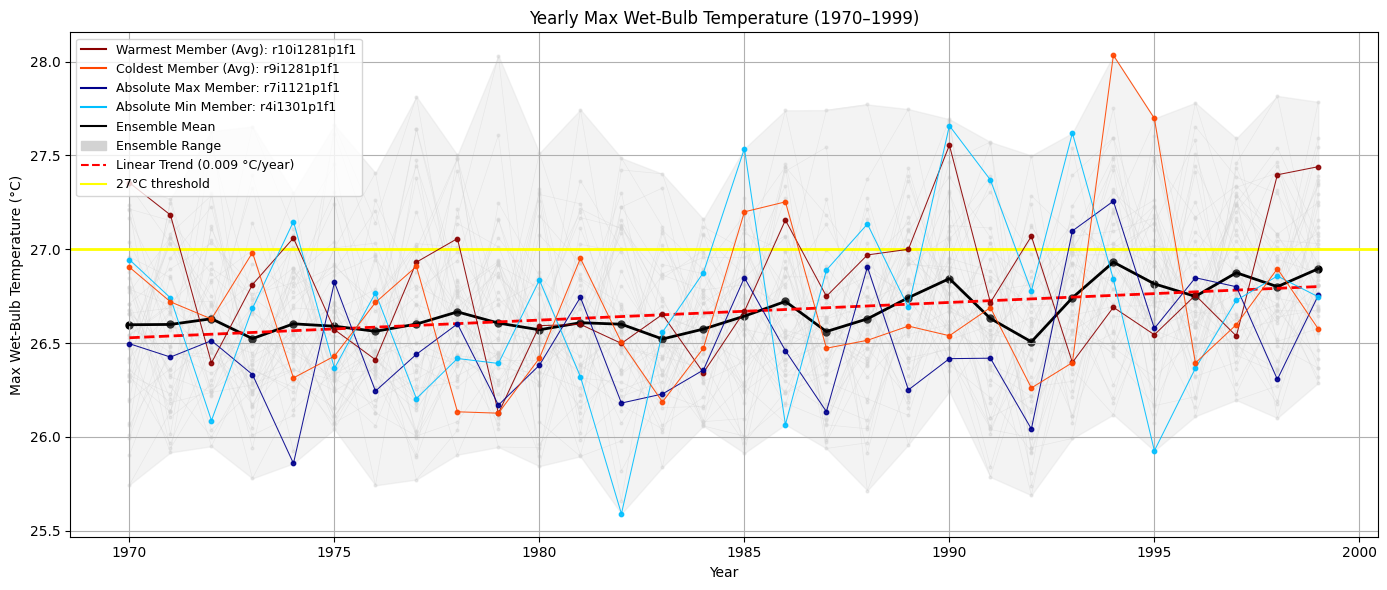

In [14]:
# Step 1: Extract the year from time and assign it as a new coordinate
years = df_historic['time'].dt.year
df_yearly = df_historic.assign_coords(year=("time", years.data))

# Step 2: Compute yearly max WBT for each member across space and time
TWB_max_per_year = df_yearly['T_WB'].max(dim=['lat', 'lon']).groupby('year').max(dim='time')

# Step 3: Ensemble statistics
mean_TWB = TWB_max_per_year.mean(dim='member_id')
min_TWB = TWB_max_per_year.min(dim='member_id')
max_TWB = TWB_max_per_year.max(dim='member_id')

# Linear regression on yearly ensemble mean
from scipy.stats import linregress
years = mean_TWB.year.values
slope, intercept, r_value, p_value, std_err = linregress(years, mean_TWB.values)
trend_line = intercept + slope * years

# Step 4: Identify warmest/coldest members (average across years)
member_means = TWB_max_per_year.mean(dim='year')
warmest_member = member_means.member_id[member_means.argmax(dim='member_id')].item()
coldest_member = member_means.member_id[member_means.argmin(dim='member_id')].item()

# Step 5: Identify members with absolute max/min values
flat_vals = TWB_max_per_year.stack(z=('year', 'member_id'))
max_member = flat_vals.member_id[flat_vals.argmax(dim='z')].item()
min_member = flat_vals.member_id[flat_vals.argmin(dim='z')].item()# Step 5: Identify members with absolute max/min values
flat_vals = TWB_max_per_year.stack(z=('year', 'member_id'))
max_member = flat_vals.member_id[flat_vals.argmax(dim='z')].item()
min_member = flat_vals.member_id[flat_vals.argmin(dim='z')].item()

# Extract values for each highlighted member
warmest_member_values = TWB_max_per_year.sel(member_id=warmest_member)
coldest_member_values = TWB_max_per_year.sel(member_id=coldest_member)
max_member_values = TWB_max_per_year.sel(member_id=max_member)
min_member_values = TWB_max_per_year.sel(member_id=min_member)

plt.figure(figsize=(14, 6))
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)
# Track which labels have already been added to avoid duplicates
plotted_labels = set()

for member in TWB_max_per_year.member_id.values:
    data = TWB_max_per_year.sel(member_id=member)

    if member == warmest_member:
        line_color = 'darkred'
        label = 'Warmest (Avg)'
        zorder = 3
    elif member == max_member:
        line_color = 'orangered'
        label = 'Absolute Max'
        zorder = 4
    elif member == coldest_member:
        line_color = 'darkblue'
        label = 'Coldest (Avg)'
        zorder = 3
    elif member == min_member:
        line_color = 'deepskyblue'
        label = 'Absolute Min'
        zorder = 4
    else:
        line_color = 'lightgray'
        label = None
        zorder = 1

    # Only add label once
    plot_label = label if label and label not in plotted_labels else None
    if plot_label:
        plotted_labels.add(label)

    plt.plot(
        years,
        data,
        color=line_color,
        linewidth=0.75 if label else 0.5,
        alpha=0.9 if label else 0.4,
        zorder=zorder,
        label=plot_label
    )
    
    plt.scatter(
        years,
        data,
        color=line_color,
        s=10 if label else 4,
        alpha=0.9 if label else 0.4,
        zorder=zorder
    )

# Ensemble mean
plt.plot(years, mean_TWB, color='black', linewidth=2, label='Ensemble Mean')
plt.scatter(years, mean_TWB, color='black', s=25)

# Shaded ensemble range
plt.fill_between(years, min_TWB, max_TWB, color='lightgray', alpha=0.25)

# Trend line
plt.plot(years, trend_line, color='red', linestyle='--', linewidth=2)

# Custom legend (in specific order)
custom_lines = [
    Line2D([], [], color='darkred', lw=1.5, label=f"Warmest Member (Avg): {warmest_member}"),
    Line2D([], [], color='orangered', lw=1.5, label=f"Coldest Member (Avg): {coldest_member}"),
    Line2D([], [], color='darkblue', lw=1.5, label=f"Absolute Max Member: {max_member}"),
    Line2D([], [], color='deepskyblue', lw=1.5, label=f"Absolute Min Member: {min_member}"),
    Line2D([], [], color='black', lw=1.5, label='Ensemble Mean'),
    Patch(facecolor='lightgray', edgecolor='lightgray', label='Ensemble Range'),
    Line2D([], [], color='red', linestyle='--', lw=1.5, label=f'Linear Trend ({slope:.3f} °C/year)'),
    Line2D([], [], color='yellow', lw=1.5, label='27°C threshold'),
]

plt.legend(handles=custom_lines, loc='upper left', fontsize=9)

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Max Wet-Bulb Temperature (°C)")
plt.title("Yearly Max Wet-Bulb Temperature (1970–1999)")
plt.grid(True)
plt.tight_layout()

plt.savefig('../analysis/figures/ensemble_members_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

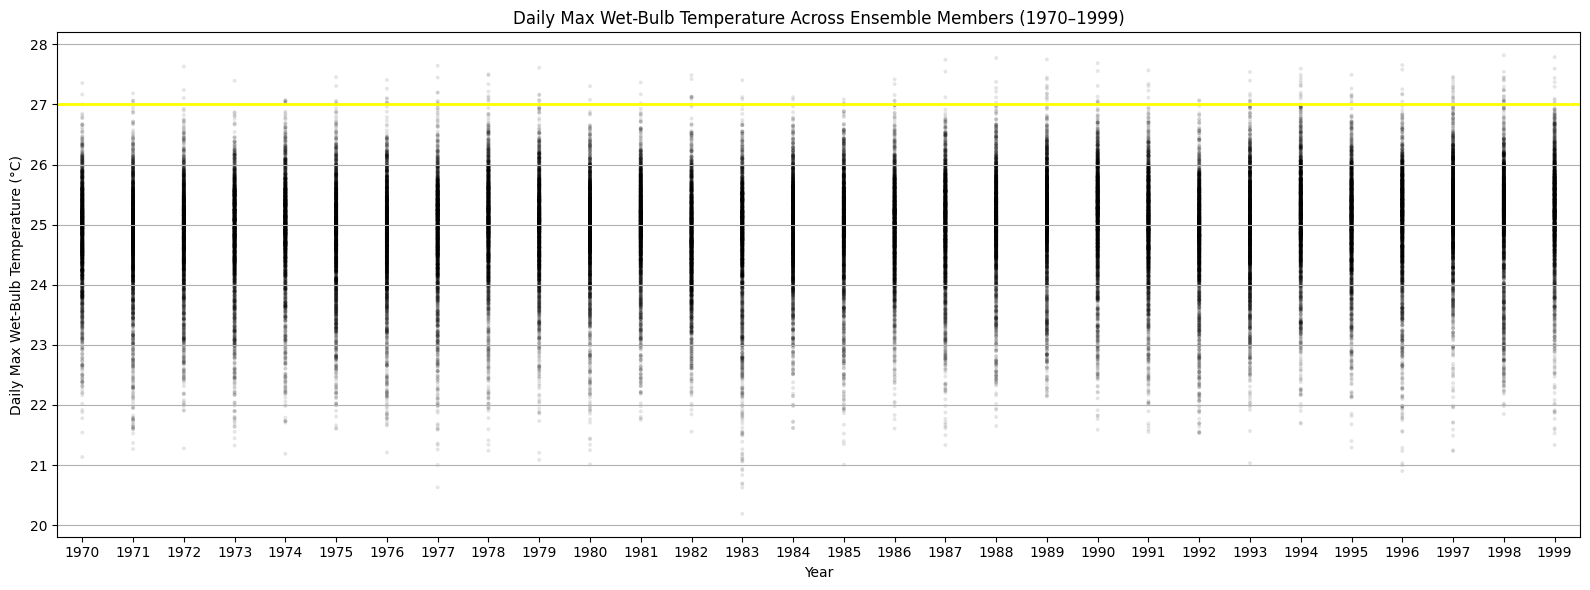

In [50]:
# Step 1: Extract year and assign as a variable (not just a coordinate)
df_yearly = df_historic.copy()
df_yearly['year'] = ('time', df_yearly['time'].dt.year.data)

# Step 2: Get daily max WBT over space (lat, lon)
TWB_daily_max = df_yearly['T_WB'].max(dim=['lat', 'lon'])  # shape: (time, member_id)

# Step 2b: Add 'year' coordinate to TWB_daily_max so we can group by it
TWB_daily_max.coords['year'] = ('time', df_yearly['year'].values)

# Step 3: Group by year
TWB_by_year = TWB_daily_max.groupby('year')

# Step 4: Build dictionary: {year: daily max WBT values across members}
yearly_data = {
    int(year): TWB_daily_max.isel(time=indices).values.flatten()
    for year, indices in TWB_by_year.groups.items()
}

# Optional: Sanity check the shape of the data
for year, data in yearly_data.items():
    print(f"Year {year}: {data.shape}")

# Step 5: Plot boxplot
plt.figure(figsize=(16, 6))
positions = sorted(yearly_data)

# Add reference line
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)

# Create boxplot
plt.boxplot(
    [yearly_data[year] for year in positions],
    positions=positions,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='black', alpha=0.5),
    medianprops=dict(color='blue', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', markersize=3, markerfacecolor='black', alpha=0.5)
)

# Step 6: Overlay individual data points
for year in positions:
    y_values = yearly_data[year]
    x_values = np.full_like(y_values, fill_value=year, dtype=np.float64)
    plt.scatter(
        x_values,
        y_values,
        color='black',
        alpha=0.1,
        s=8,
        linewidths=0,
        edgecolors='none'
    )

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Daily Max Wet-Bulb Temperature (°C)")
plt.title("Daily Max Wet-Bulb Temperature Across Ensemble Members (1970–1999)")
plt.grid(True, axis='y')
plt.tight_layout()

# Optional save
# plt.savefig('../analysis/figures/ensemble_members_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()


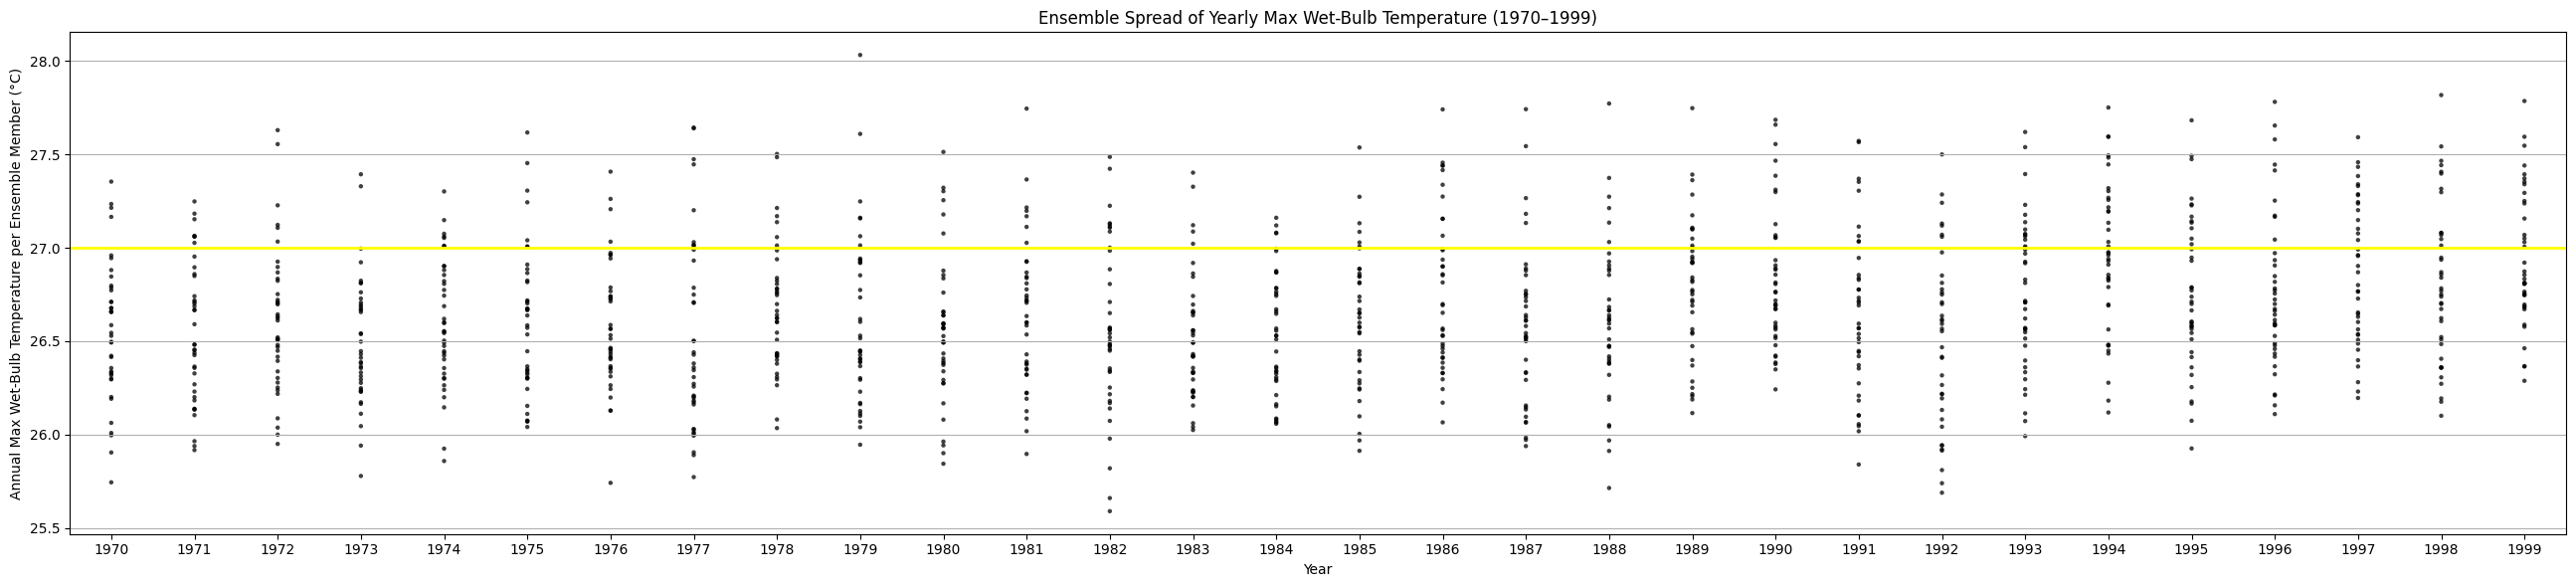

In [15]:
# Step 1: Extract the year from time and assign it as a new coordinate
years = df_historic['time'].dt.year
df_yearly = df_historic.assign_coords(year=("time", years.data))

# Step 2: Compute yearly max WBT for each member across space and time
TWB_max_per_year = df_yearly['T_WB'].max(dim=['lat', 'lon']).groupby('year').max(dim='time')

# ompute yearly max WBT per ensemble member
TWB_yearly_max_by_member = TWB_daily_max.groupby('year').max(dim='time')

# Build dictionary: {year: array of member max WBT values}
yearly_member_max_data = {
    int(year): TWB_yearly_max_by_member.sel(year=year).values
    for year in TWB_yearly_max_by_member.year.values
}

# Plot
plt.figure(figsize=(26, 6))
positions = sorted(yearly_member_max_data)
plt.axhline(y=27, color='yellow', linestyle='-', linewidth=2)
# Boxplot
plt.boxplot(
    [yearly_member_max_data[year] for year in positions],
    positions=positions,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='black', alpha = 0.5),
    medianprops=dict(color='blue', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', markersize=3, markerfacecolor='black', alpha=0.5)
)
# Overlay all individual data points
for i, year in enumerate(positions):
    y_values = yearly_member_max_data[year]
    x_values = np.full_like(y_values, fill_value=year, dtype=np.float64)
    plt.scatter(
        x_values,
        y_values,
        color='black',
        alpha=0.75,
        s=10,
        linewidths=0.75,
        edgecolors='none'
    )
# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Annual Max Wet-Bulb Temperature per Ensemble Member (°C)")
plt.title("Ensemble Spread of Yearly Max Wet-Bulb Temperature (1970–1999)")
plt.grid(True, axis='y')
plt.tight_layout()

#plt.savefig('../analysis/figures/ensemble_members_1970_1999.png', dpi=1000, bbox_inches='tight')

plt.show()

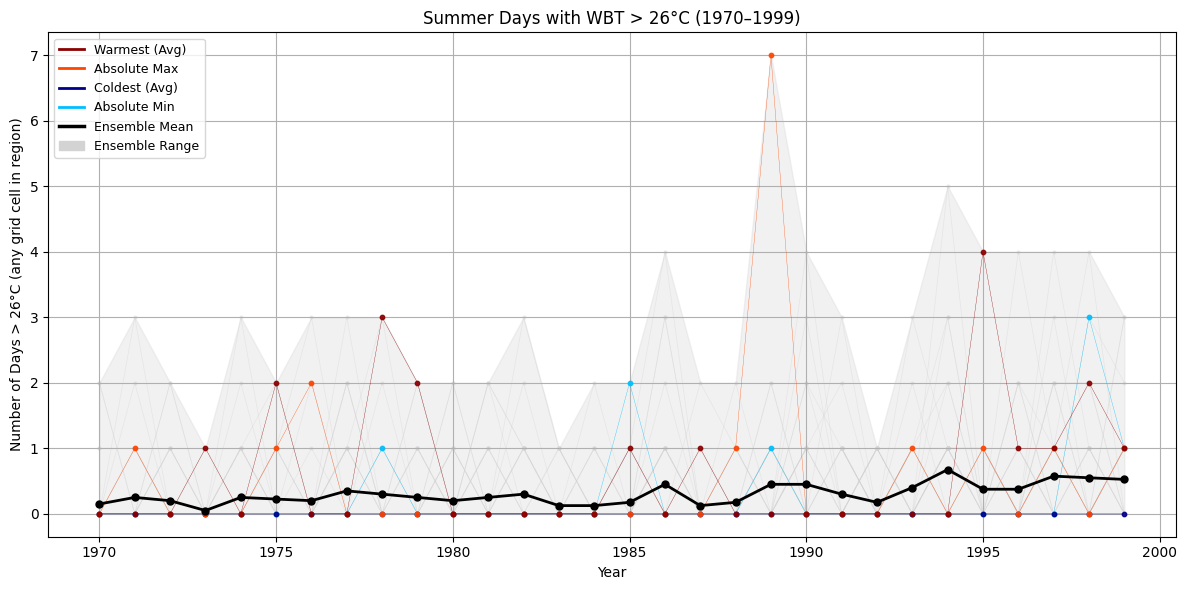

In [22]:

# from scipy.stats import linregress  # Optional for trend

# 1. Subset to region
regional_data = df_historic['T_WB'].sel(lat=slice(34, 45), lon=slice(-10, 20))

# 2. Boolean mask: grid cells over 26°C
above_threshold = regional_data > 27

# 3. Reduce over space: was any grid cell above threshold on a given day?
any_gridcell_exceeds = above_threshold.any(dim=['lat', 'lon'])

# 4. Limit to summer months (June–August)
summer = any_gridcell_exceeds.sel(time=any_gridcell_exceeds['time'].dt.month.isin([6, 7, 8]))

# 5. Count number of days above threshold per year per ensemble member
days_above_per_year = summer.groupby('time.year').sum(dim='time')  # (member_id, year)

# 6. Ensemble statistics
ensemble_mean = days_above_per_year.mean(dim='member_id')
ensemble_min = days_above_per_year.min(dim='member_id')
ensemble_max = days_above_per_year.max(dim='member_id')

# 7. Identify key ensemble members
member_means = days_above_per_year.mean(dim='year')
warmest_member = member_means.member_id[member_means.argmax(dim='member_id')].item()
coldest_member = member_means.member_id[member_means.argmin(dim='member_id')].item()

flat_vals = days_above_per_year.stack(z=('year', 'member_id'))
max_member = flat_vals.member_id[flat_vals.argmax(dim='z')].item()
min_member = flat_vals.member_id[flat_vals.argmin(dim='z')].item()

# Optional: Linear regression on ensemble mean
years = ensemble_mean.year.values
# slope, intercept, r_value, p_value, std_err = linregress(years, ensemble_mean.values)
trend_line = intercept + slope * years

# 8. Plotting
plt.figure(figsize=(12, 6))
# Track labels already used to avoid duplicates in the legend
plotted_labels = set()

for member in days_above_per_year.member_id.values:
    data = days_above_per_year.sel(member_id=member)

    if member == warmest_member:
        color = 'darkred'
        label = 'Warmest (Avg)'
    elif member == max_member:
        color = 'orangered'
        label = 'Absolute Max'
    elif member == coldest_member:
        color = 'darkblue'
        label = 'Coldest (Avg)'
    elif member == min_member:
        color = 'deepskyblue'
        label = 'Absolute Min'
    else:
        color = 'lightgray'
        label = None

    plot_label = label if label and label not in plotted_labels else None
    if plot_label:
        plotted_labels.add(label)

    plt.plot(
        days_above_per_year.year,
        data,
        color=color,
        linewidth=0.5 if label is None else 0.25,
        alpha=0.9 if label else 0.4,
        label=plot_label,
        zorder=2 if label else 1
    )
    plt.scatter(
        days_above_per_year.year,
        data,
        color=color,
        s=10 if label else 4,
        alpha=0.9 if label else 0.4,
        zorder=2 if label else 1
    )

# Plot ensemble mean
plt.plot(
    ensemble_mean.year,
    ensemble_mean,
    color='black',
    linewidth=2,
    marker='o',
    markersize=5,
    label='Ensemble Mean',
    zorder=3
)

# Fill ensemble range
plt.fill_between(
    ensemble_mean.year,
    ensemble_min,
    ensemble_max,
    color='lightgray',
    alpha=0.3,
    label='Ensemble Range',
    zorder=0
)

# Optional: plot trend line
# plt.plot(years, trend_line, color='red', linestyle='--', linewidth=2, label=f'Trend ({slope:.2f} days/year)')

# Custom legend to control order
custom_legend = [
    Line2D([], [], color='darkred', lw=2, label='Warmest (Avg)'),
    Line2D([], [], color='orangered', lw=2, label='Absolute Max'),
    Line2D([], [], color='darkblue', lw=2, label='Coldest (Avg)'),
    Line2D([], [], color='deepskyblue', lw=2, label='Absolute Min'),
    Line2D([], [], color='black', lw=2.5, label='Ensemble Mean'),
    Patch(color='lightgray', label='Ensemble Range'),
    # Line2D([], [], color='red', linestyle='--', lw=2, label=f'Trend ({slope:.2f} days/year)')  # Optional
]

plt.legend(handles=custom_legend, loc='upper left', fontsize=9)

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Number of Days > 26°C (any grid cell in region)")
plt.title("Summer Days with WBT > 26°C (1970–1999)")
plt.grid(True)
plt.tight_layout()

# Save and show
#plt.savefig('../analysis/figures/threshold_exceed_1970_1999.png', dpi=1000, bbox_inches='tight')
plt.show()


# Future

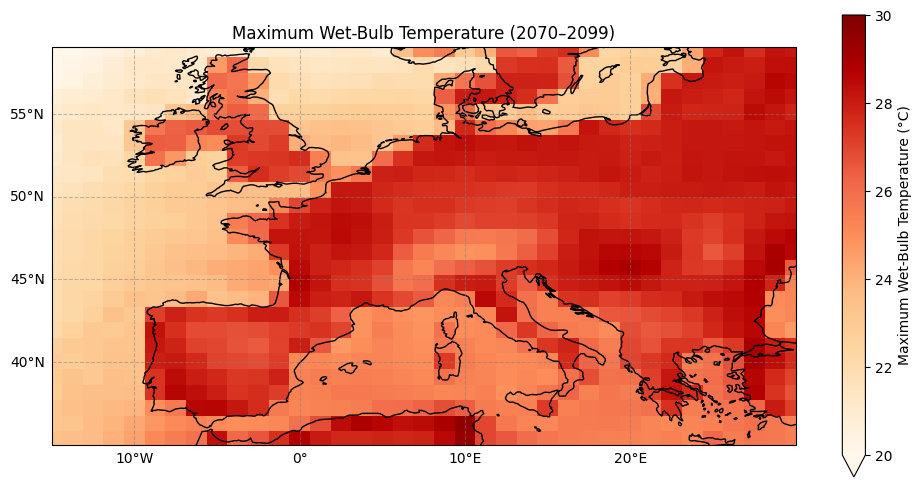

In [11]:

# Compute max wet-bulb temperature at each grid cell
max_T_WB = df_future['T_WB'].max(dim=['member_id', 'time'])

# Plot the maximum T_WB
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
max_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': 'Maximum Wet-Bulb Temperature (°C)'},
    vmin=20, vmax=30)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title('Maximum Wet-Bulb Temperature (2070–2099)')

plt.savefig('../analysis/figures/max_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()

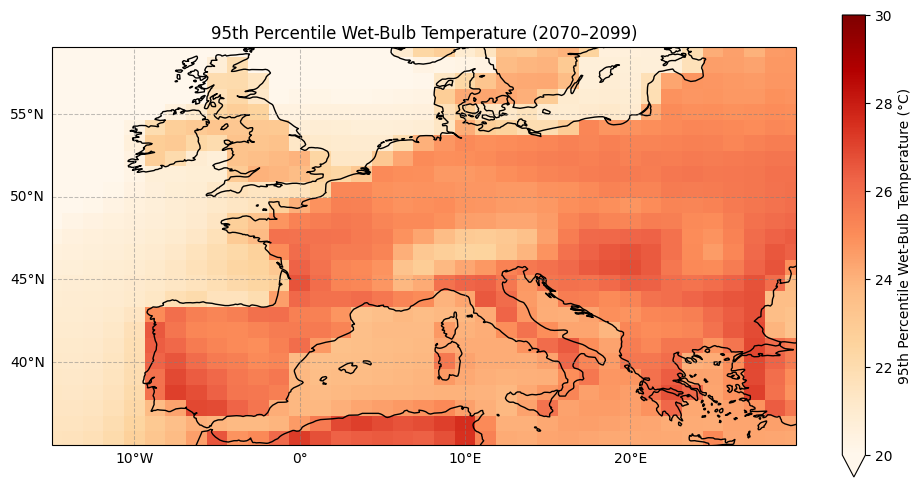

In [12]:
# Compute the 95th percentile wet-bulb temperature at each grid cell
p95_T_WB = df_future['T_WB'].quantile(0.95, dim=['member_id', 'time'])


plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the 95th percentile T_WB
p95_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # or try 'inferno', 'plasma', 'cividis'
    cbar_kwargs={'label': '95th Percentile Wet-Bulb Temperature (°C)'},
    vmin=20, vmax=30  # adjust range to your data
)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title('95th Percentile Wet-Bulb Temperature (2070–2099)')

plt.savefig('../analysis/figures/p95_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()


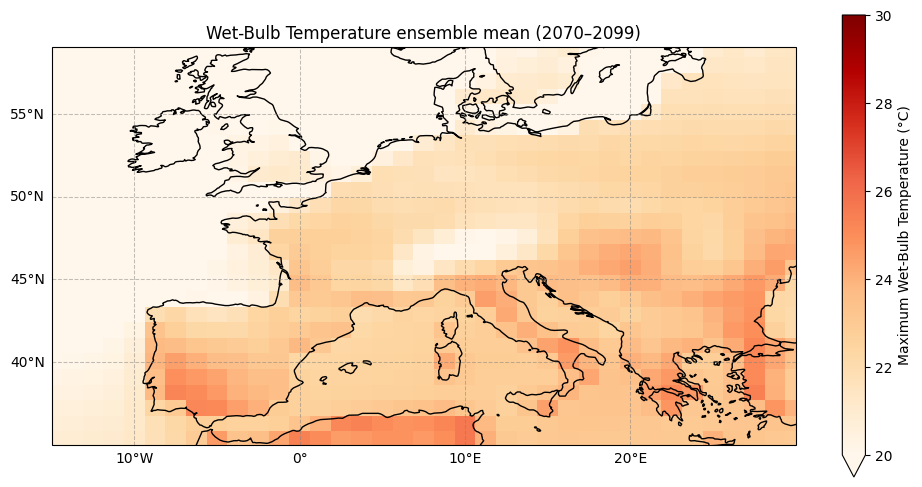

In [13]:
# Compute ensemble mean wet-bulb temperature at each grid cell
mean_T_WB = df_future['T_WB'].mean(dim=['member_id', 'time'])

plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adjust color range as needed (e.g., 15 to 30 °C)
mean_T_WB.plot(
    ax=ax,
    cmap='OrRd',  # 'viridis' or 'inferno' also work well
    cbar_kwargs={'label': 'Maximum Wet-Bulb Temperature (°C)'},
    vmin=20, vmax=30)

# Add map features
ax.coastlines()
ax.set_extent([-15, 30, 35, 57])
# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title('Wet-Bulb Temperature ensemble mean (2070–2099)')

plt.savefig('../analysis/figures/ensemblemean_T_WB_2070_2099.png', dpi=1000, bbox_inches='tight')

plt.show()